In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [7]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rajra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [21]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [31]:
# --- 1. Load the IMDb CSV Dataset ---
file_name = 'IMDB Dataset.csv' 

try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"Error: Could not find the file '{file_name}'")
    print("Please make sure it's in your C:\\Users\\rajra\\Project folder.")
    raise

print("Dataset loaded successfully.")
print("Original data counts (already balanced):")
# The sentiment column is already 'positive' or 'negative'
df['sentiment'] = df['sentiment'].apply(lambda x: 'Positive' if x == 'positive' else 'Negative')
print(df['sentiment'].value_counts())

print("\nDisplaying the first 5 rows of the DataFrame:")
df.head()

Dataset loaded successfully.
Original data counts (already balanced):
sentiment
Positive    25000
Negative    25000
Name: count, dtype: int64

Displaying the first 5 rows of the DataFrame:


,review,sentiment
0,One of the other reviewers has mentioned that ...,Positive
1,A wonderful little production. <br /><br />The...,Positive
2,I thought this was a wonderful way to spend ti...,Positive
3,Basically there's a family where a little boy ...,Negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",Positive


In [32]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [27]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [33]:
df.duplicated().sum()

np.int64(418)

In [34]:
df = df.drop_duplicates()

In [35]:
df.duplicated().sum()

np.int64(0)

In [36]:
# --- 2. Text Preprocessing ---
stop_words = set(stopwords.words('english'))
negations = {'not', 'no', 'never', "don't", "shouldn't", "wasn't", "weren't", 
             "haven't", "hasn't", "hadn't", "doesn't", "didn't", "can't", "couldn't"}
stop_words = stop_words - negations

def clean_text(text):
    text = str(text).lower() 
    text = re.sub(r'<br />', ' ', text) # Remove HTML breaks
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation/numbers
    tokens = word_tokenize(text) 
    clean_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(clean_tokens) 

print("\nCleaning text data (this will take a few minutes for 50,000 reviews)...")
# The review column is named 'review'
df['clean_text'] = df['review'].apply(clean_text)
print("Cleaning complete.")


Cleaning text data (this will take a few minutes for 50,000 reviews)...
Cleaning complete.


In [37]:
# --- 3. Split the Data ---
# The data is already balanced, so no upsampling is needed.
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(y_train)}")
print(f"Testing set size: {len(y_test)}")


Training set size: 39665
Testing set size: 9917


In [38]:
# --- 4. Vectorizing and Training ---
tfidf_vectorizer = TfidfVectorizer(max_features=10000) # Use a large vocabulary
model = LogisticRegression(max_iter=1000) 

print("\nFitting vectorizer on training data...")
X_train_vec = tfidf_vectorizer.fit_transform(X_train)

print("Training model...")
model.fit(X_train_vec, y_train)
print("Model trained successfully.")


Fitting vectorizer on training data...
Training model...
Model trained successfully.


In [39]:
# --- 5. Evaluate the Model ---
print("\nEvaluating model on the unseen test set...")
X_test_vec = tfidf_vectorizer.transform(X_test)
y_pred = model.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- FINAL MODEL ACCURACY: {accuracy * 100:.2f}% ---")
print("\nClassification Report (This is the true score):")
print(classification_report(y_test, y_pred))


Evaluating model on the unseen test set...

--- FINAL MODEL ACCURACY: 89.07% ---

Classification Report (This is the true score):
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      4940
    Positive       0.88      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [40]:
# --- 6. Test with new reviews ---
print("\n--- Testing with your reviews ---")
reviews_to_test = [
    "This product was a complete waste of money. It broke after one day!",
    "It's an okay product, not great but not terrible.",
    "Wow! I love this, it's the best purchase I have made all year."
]

for review in reviews_to_test:
    cleaned_review = clean_text(review)
    vectorized_review = tfidf_vectorizer.transform([cleaned_review])
    prediction = model.predict(vectorized_review)
    print(f"\nReview: '{review}'")
    print(f"Predicted Sentiment: {prediction[0]}")


--- Testing with your reviews ---

Review: 'This product was a complete waste of money. It broke after one day!'
Predicted Sentiment: Negative

Review: 'It's an okay product, not great but not terrible.'
Predicted Sentiment: Negative

Review: 'Wow! I love this, it's the best purchase I have made all year.'
Predicted Sentiment: Positive


In [42]:
!pip install matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/114.6 kB ? eta -:--:--
     --- ------------------------------------ 10.2/114.6 kB ? eta -:--:--
     -------------------------------------  112.6/114.6 kB 1.3 MB/s eta 0:00:01
     ------------------------------------ 114.6/114.6 kB 957.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
    --------------------------------------- 0.1/8.1 MB 7.0 MB/s eta 0:00:02
   - -------------------------------------- 0.3/8.1 MB 3.5 MB/s eta 0:00:03
   -- ------------------------------------- 0.6/8.1 MB 4.1 MB/s eta 0:00:02
   --- ------------------------------------ 0.7/8.1 MB 4.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/8.1 MB 4.8 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.1 MB 4.9 MB/s eta 0:00:02
   ------- ----------------------------


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

Displaying Sentiment Distribution Bar Chart...


C:\Users\rajra\AppData\Local\Temp\ipykernel_24156\3235850178.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment',


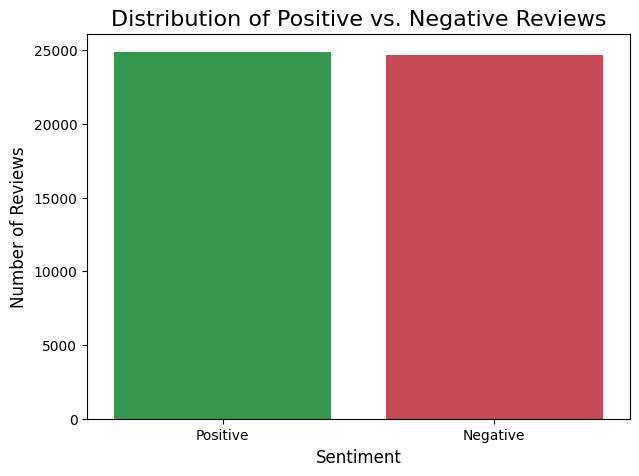

In [44]:
# --- Sentiment Distribution Bar Chart ---

print("Displaying Sentiment Distribution Bar Chart...")

# Set the size of the graph
plt.figure(figsize=(7, 5)) 

# Create the bar plot
# We use a custom palette: green for Positive, red for Negative
sns.countplot(data=df, x='sentiment', 
              palette={'Positive': '#28a745', 'Negative': '#dc3545'}, 
              order=['Positive', 'Negative']) 

# Add titles and labels
plt.title('Distribution of Positive vs. Negative Reviews', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Display the graph
plt.show()

## Do people tend to write longer positive reviews, or are their negative rants longer?

Calculating word counts for each review...
Plotting reviews with less than 800 words.
Displaying Review Word Count Distribution Plot...


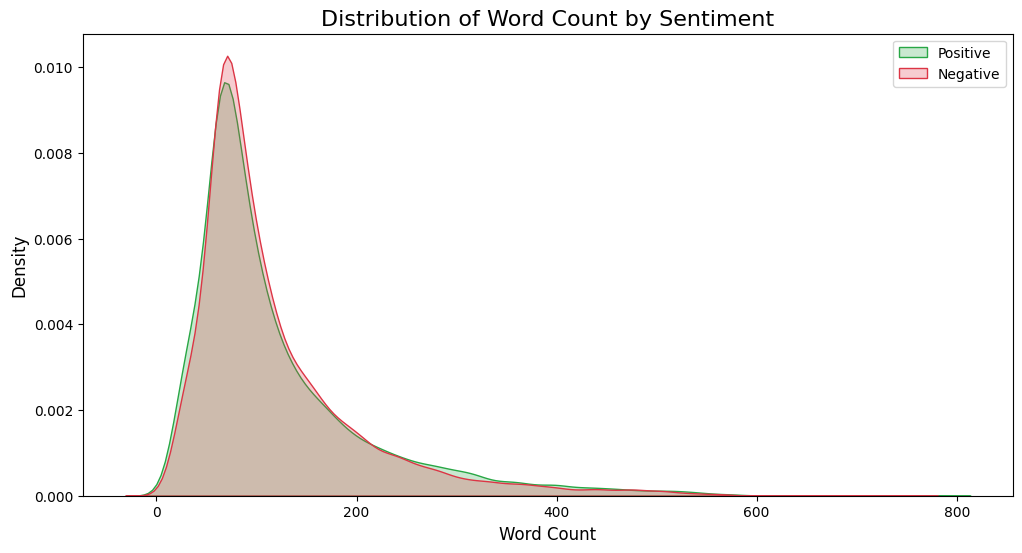

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Create a new 'word_count' column ---
# We calculate the word count based on the *cleaned* text
print("Calculating word counts for each review...")
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# --- 2. Filter out extreme outliers for a cleaner graph ---
# Some reviews are thousands of words long and skew the graph.
# We'll focus on reviews under 800 words for a better view.
word_count_limit = 800
df_filtered = df[df['word_count'] < word_count_limit]
print(f"Plotting reviews with less than {word_count_limit} words.")

# --- 3. Create the Density Plot ---
print("Displaying Review Word Count Distribution Plot...")
plt.figure(figsize=(12, 6))

# Use seaborn's kdeplot to draw a smooth distribution curve
# We set `fill=True` to shade the area under the curve
# We plot Positive and Negative separately to compare them
sns.kdeplot(df_filtered[df_filtered['sentiment'] == 'Positive']['word_count'], 
            label='Positive', color='#28a745', fill=True)
        
sns.kdeplot(df_filtered[df_filtered['sentiment'] == 'Negative']['word_count'], 
            label='Negative', color='#dc3545', fill=True)

# Add titles and labels
plt.title('Distribution of Word Count by Sentiment', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()